# Project 2: Digit Classification Naive Bayes

**Solution**

# Intro
---
In this project, you'll continue working on your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more.
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b>


## Grading
---
 - Make sure to answer every part in every question.
 - There are 6 questions, each equally weighted and an additional bonus question.
 - The extra credit question will be graded based on your attempts at feature engineering and resulting improved accuracy.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean, well commented,
  -  if the functions or answers are too long.

## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

## Additional Reading and notes
---
If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'1.2.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X.iloc[shuffle], Y.iloc[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_).
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

Question 1: Looking at the change in accuracies from no guassian blur to partcial blur, to full blur, I can see that when applying the blur to both the training data and the data to evaluation data I get better results. it seems to me that finding the right amount of blur can enable the model to become better at perdiction.

In [4]:
def blur(data):
  ### STUDENT START ###
  blurred_data = []
  w = 0.5  # this weighting results in best dev accuracy for filter train & dev
  #data = np.array(data1)[:, np.newaxis]
  for i in range(data.shape[0]):
    grid = data.iloc[i].to_numpy().reshape(28, 28)
    f = np.zeros((28, 28))
    for i in range(28):
      for j in range(28):
        f[i,j] = grid[i,j] + np.sum(grid[i-1:i+2, j-1:j+2]) / w
    blurred_data.append(f.flatten())
  return blurred_data
   ### STUDENT END ###

def Q1():
  ### STUDENT START ###
  # store accuracies for models with filtering
  acc = [] # 0 - no filter ; 1 - filter train only ; 2 - filter dev only ; 3 - filter both
  # NOTE! filter only applies to image data, no change to labels needed.
  filteredTrain = blur(mini_train_data)
  filteredDev = blur(dev_data)

  # create 1nn model
  knn = KNeighborsClassifier(n_neighbors=1)

  # not using the filter
  knn.fit(mini_train_data, mini_train_labels)
  model_y = knn.predict(dev_data)
  myReport = classification_report(dev_labels, model_y, output_dict=True)
  acc.append(myReport["accuracy"])

  # filter training data, NOT dev
  knn.fit(filteredTrain, mini_train_labels)
  model_y = knn.predict(dev_data)
  myReport = classification_report(dev_labels, model_y, output_dict=True)
  acc.append(myReport["accuracy"])

  # filter dev data, NOT training
  knn.fit(mini_train_data, mini_train_labels)
  model_y = knn.predict(filteredDev)
  myReport = classification_report(dev_labels, model_y, output_dict=True)
  acc.append(myReport["accuracy"])

  # filter both
  knn.fit(filteredTrain, mini_train_labels)
  model_y = knn.predict(filteredDev)
  myReport = classification_report(dev_labels, model_y, output_dict=True)
  acc.append(myReport['accuracy'])

  # showing accuracies:
  print(f"\n\naccuracies: \nNo Filters: {acc[0]} \nTraining data filtered ONLY: {acc[1]} \nDev data filtered ONLY: {acc[2]} \nBoth filtered: {acc[3]}")
  ### STUDENT END ###

Q1()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `



accuracies: 
No Filters: 0.884 
Training data filtered ONLY: 0.143 
Dev data filtered ONLY: 0.588 
Both filtered: 0.903


### Question 2: Modeling your data and experimenting with different Naive Bayes models.
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



ANSWER: the accuracy of the Bernoulli model was higher than the multinomial in my experiement, and I think the reason why the Bern model did better was because of its binary nature. I think that possibly the multinomial model might be over-complecating the guessing. I think that multinomial model would be better suited for something with more features.

In [5]:
# Solution with binarization by explicit binarize function

# pre-processed data, binarize func
# not used, used binarize param
def myBinarize(data):
  newIM = np.zeros(data.shape)
  newIM[(data > 0.1)] = 1
  return newIM

# pre-processed data, trianarize func
def trianarize(data):
  tri_data = []
  for i in range(data.shape[0]):
    im = data.iloc[i].to_numpy().reshape(28,28)
    newIM = np.zeros((28,28)) # blank canvas for binarize/trianarize
    for i in range(28):
      for j in range(28):
        if im[i][j] < 0.1 :
          newIM[i][j] = 0
        elif im[i][j] > 0.9 :
          newIM[i][j] = 2
        else:
          newIM[i][j] = 1
    tri_data.append(newIM.flatten())
  return tri_data


def Q2():
  ### STUDENT START ###
  # Bernoulli model - binarize
  bern = BernoulliNB(binarize=0.1)
  bern.fit(mini_train_data, mini_train_labels)
  #bern_y = bern.predict(dev_data)
  print("bernoulli score: ",bern.score(dev_data, dev_labels))

  # Multinomial - trinarize
  mini_tri = trianarize(mini_train_data)
  dev_tri = trianarize(dev_data)
  multi = MultinomialNB()
  multi.fit(mini_tri, mini_train_labels)
  print("multinomial score: ", multi.score(dev_tri, dev_labels))

  #print(f"transformed tri data:  \n{mini_tri[100]} \nraw data \n{mini_train_data.iloc[100].to_numpy().reshape(28,28)}")
  ### STUDENT END ###

Q2()

bernoulli score:  0.814
multinomial score:  0.807


### Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation.
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



ANSWER: So, looking at the results gather from GridSearchCV, it looks like the alpha values do not have a linear relationship to accuracy. with the super small alpha value, 1.0e-10, doing better than 0.0001, 0.001, and 0.01; but the largest alpha value, 10, doing the best. This is according to the rank_test_score array returned by .cv_results_

when also value is new 0, it garners a poor score. However, when the alpha value is farther away from zero, a better score is awarded. im not sure what i was supposed to expect, but it wasn't this.

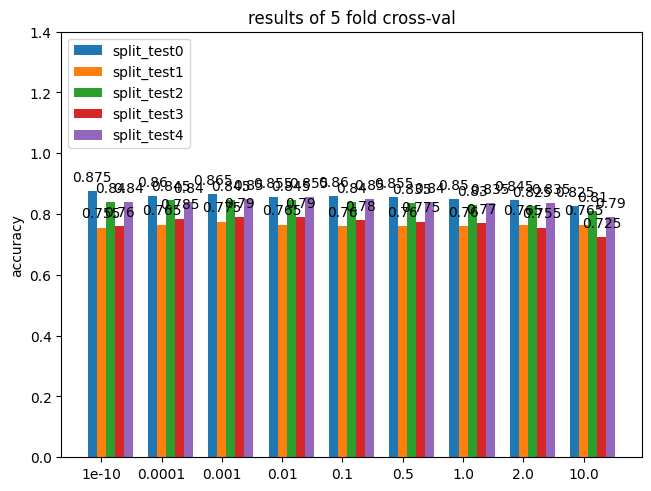

In [6]:
def Q3(alphas):
  ### STUDENT START ###
  params = [alphas]
  # create bern model
  bern = BernoulliNB()
  bernGrid = GridSearchCV(bern, param_grid=params, scoring='accuracy')
  bernGrid.fit(mini_train_data, mini_train_labels)
  myResults = bernGrid.cv_results_ # cv_results_ returns dict
  #pprint.pprint(myResults)
  # store the myResults into data frame, create graph x -> alphas, y -> acc's
  mydf = pd.DataFrame(myResults)
  #print(mydf)
  #print("params: ", mydf[['params']], "\nsplit0 test: ", mydf[["split0_test_score"]])
  pltData = {'split_test0' : mydf["split0_test_score"],
             'split_test1' : mydf["split1_test_score"],
             'split_test2' : mydf["split2_test_score"],
             'split_test3' : mydf["split3_test_score"],
             'split_test4' : mydf["split4_test_score"]}
  #pprint.pprint(pltData)

  # bar graph ref: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
  # x -> alphas mydf["params"]
  xlab = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
  x = np.arange(len(xlab)) # label locations, start=0,stop=90,step=10
  width = 0.15
  multiplier = 0

  fig, ax = plt.subplots(layout='constrained')
  for test, result in pltData.items():
    # calculates location of bar
    offset = width * multiplier
    rects = ax.bar(x + offset, result, width, label=test)
    ax.bar_label(rects, padding=5)
    multiplier += 1

  ax.set_ylabel('accuracy')
  ax.set_xticks(x+width, xlab)
  ax.set_title('results of 5 fold cross-val')
  ax.legend(loc='upper left')
  ax.set_ylim(0,1.4)



  ### STUDENT END ###

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas)

### Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well.
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model.
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

In [7]:
def Q4():
  ### STUDENT END ###
  # create gaussian model without any modifications
  gauss = GaussianNB()
  gauss.fit(mini_train_data, mini_train_labels)
  gauss_y = gauss.score(dev_data, dev_labels)
  print(f"gauss_y results with default var smooth: {gauss_y}")

  # remember that NB does P(feature|label)
  # try partial fit
  # increase var_smoothing param so that the model is more forgiving
  gauss = GaussianNB(var_smoothing = 0.1)
  gauss.partial_fit(mini_train_data, mini_train_labels, np.unique(mini_train_labels))
  gauss_y = gauss.predict(dev_data)
  myReport = classification_report(dev_labels, gauss_y, output_dict=True)
  print("partial fit predict accuracy with 0.1 var smooth value: ", myReport["accuracy"])


  ### STUDENT END ###

Q4()

gauss_y results with default var smooth: 0.593
partial fit predict accuracy with 0.1 var smooth value:  0.817


ANSWER: In the first Gaussian NB model, I get an accuracy of ~59%, which isn't very good. The Gaussian NB model is looking at cases where certian features are involved in certian results. I increased the var_smoothing value to make the cases become more general and less specific. Since there is a lot of varience in my data set, I want the model to be less strict on what cases result in outcomes. I tried the values, 0.0001, 0.001, 0.01, and ended with 0.1 which gives me an accuracy of ~82%.

### Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



ANSWER: the generated images are hard to read, the zero is the clearest generated image. i think that if the model is trained on more images it would probable generate better images. the training digit images are 100% better than the generated ones.

also, for some reason, my scatter plot's of the digits came out side ways? not sure why.

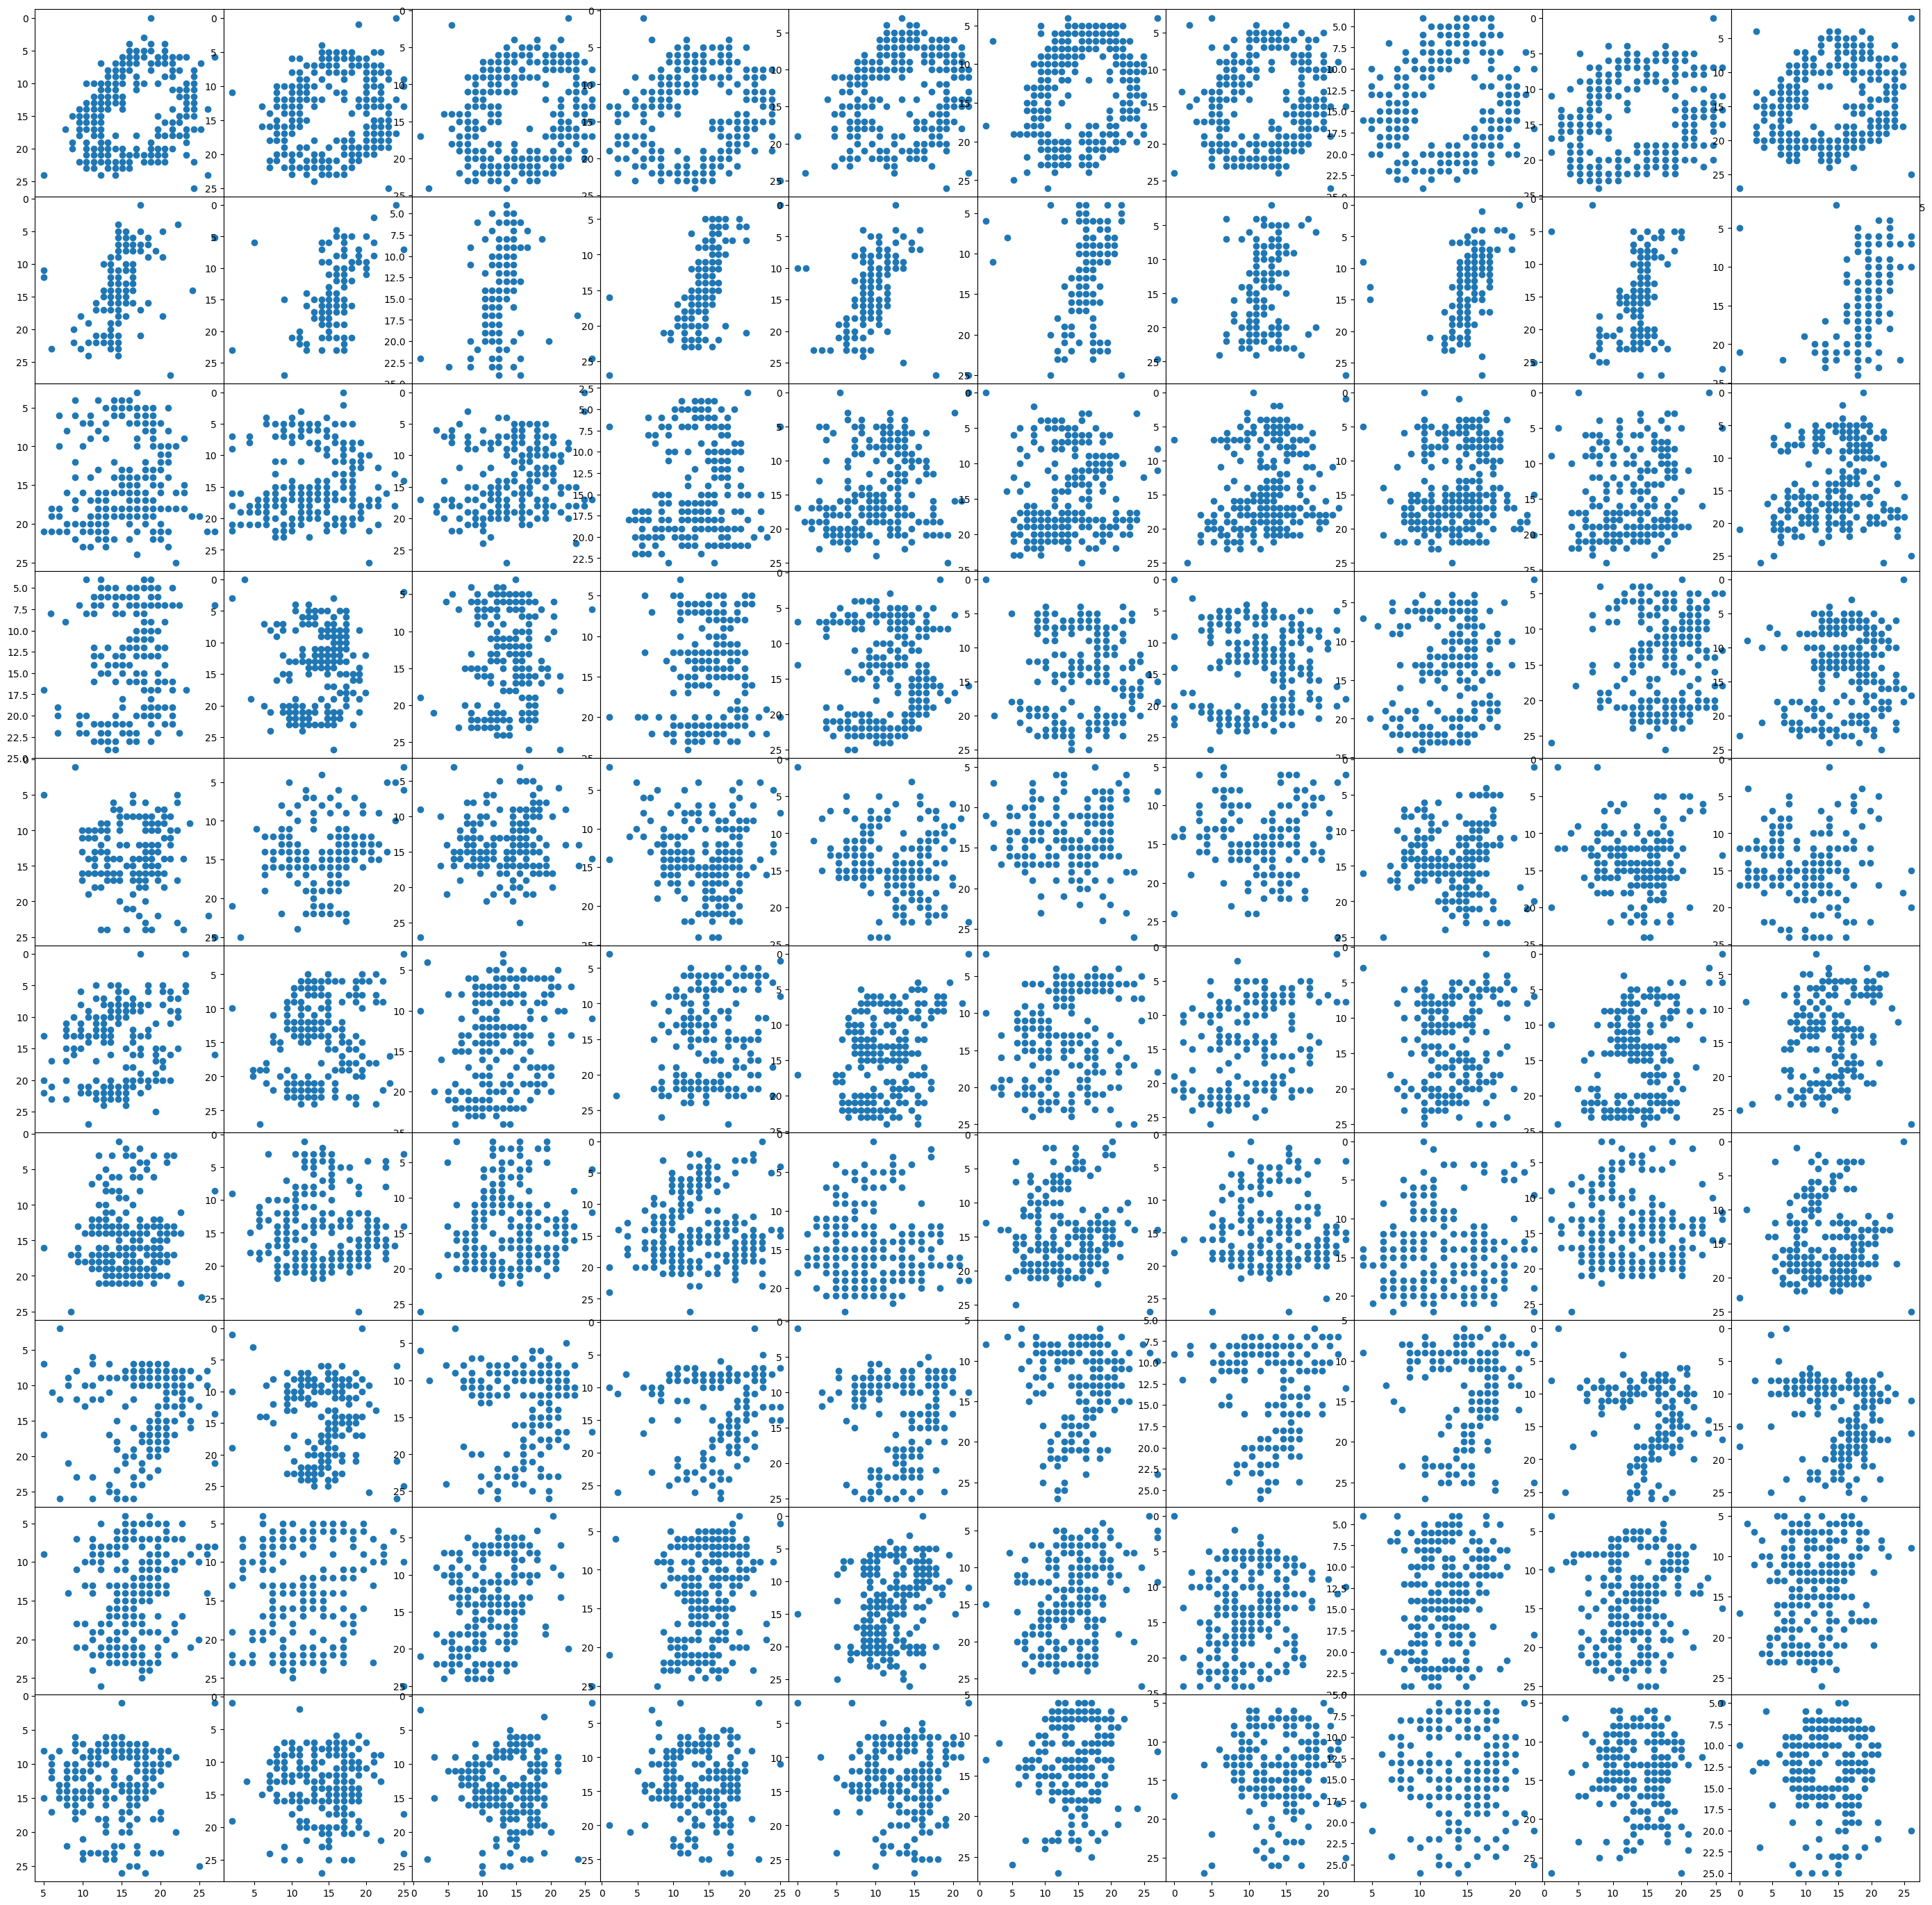

In [8]:
def generateDigit(log_prob):
  # passing log probabilities
  r = np.random.rand(784)
  d = np.zeros(784)
  for i in range(784):
    # converting back to probs, if greater than this prob = 0
    if r[i] < np.exp(log_prob[i]) : d[i] = 1
  digMat = d.reshape((28,28))
  cord_x = []
  cord_y = []
  for i in range(28):
    for j in range(28):
      if digMat[i][j] == 1:
        cord_x.append(i)
        cord_y.append(j)
  return digMat, cord_x, cord_y


def Q5(num_examples):
  ### STUDENT START ###
  # create bern model
  bern = BernoulliNB(binarize=0.1)
  bern.fit(mini_train_data, mini_train_labels)
  #bern.predict()

  # now that we are generating digits, lets plot them
  fig, ax = plt.subplots(10, 10, figsize=(35,35))

  # generating 10 examples of each digit 0-9
  # only send in the log prob for a specific class!!
  for i in range(10):
    for n in range(10):
      digit, x, y = generateDigit(bern.feature_log_prob_[i])

      ax[i, n].scatter(y, x)
      ax[i, n].invert_yaxis()

  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()


  ### STUDENT END ###

Q5(10)

### Question 6: Model Calibration

---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9.
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance:
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket.
    - So, for each prediction:
       - Find the bucket whose range includes the estimated posterior probability,
       - and update "correct" and "total" counters accordingly.
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.



ANSWER: I would say, according to the definitions above, that this model is between weakly calibrated and strongly calibrated. the model is more accurace when it "says" it is more accurace, and ~97% of the predictions fall into the 0.9+ buckets. when the model's confidence is between 0.9999999999999 and 1.0, it is ~93% accurcate which falls inline with the strongly calibrated definition. however, when the model's confidence is between 0.90 and 0.9999999999999, it is only accurate about ~65% of the time (average: 0.433, 0.458, 0.652, 0.774, 0.788, 0.791).

i think the calibration for this Bernoulli Naive Bayes model is between Strongly calibrated and weakly calibrated. I would lean more towards strongly calibrated though.

In [9]:
# filter function to return the count of elements in given range
# pass confidence ranger: upper, lower
# pass confidence of preds: myPreds
# pass model's pred labels: y
def myCounter(myPreds, upper, lower, y):
  count = 0
  correct = 0
  for i in range(len(myPreds)):
    digitPos = np.where(myPreds[i] == max(myPreds[i]))[0]
    # updates confidence score
    if myPreds[i][digitPos] >= lower and myPreds[i][digitPos] <= upper:
      count += 1
      # updates if pred is correct
      if digitPos == int(y[i]) and y[i] == dev_labels.iloc[i]:
        correct += 1
  # count -> total preds in this range, correct -> total correct preds
  return count, correct

def Q6(buckets, correct, total):
  ### STUDENT START ###
  # create model, using best alpha
  bern = BernoulliNB(binarize=0, alpha=0.001)
  bern.fit(mini_train_data, mini_train_labels)
  # model's confidence of prediction
  myPreds = bern.predict_proba(dev_data)
  # model's predictions
  y = bern.predict(dev_data)

  # pass to myCounter function to update buckets accordingly
  total[0], correct[0] = myCounter(myPreds, 0.5, 0.0, y)
  total[1], correct[1] = myCounter(myPreds, 0.9, 0.5, y)
  total[2], correct[2] = myCounter(myPreds, 0.999, 0.9, y)
  total[3], correct[3] = myCounter(myPreds, 0.99999, 0.999, y)
  total[4], correct[4] = myCounter(myPreds, 0.9999999, 0.99999, y)
  total[5], correct[5] = myCounter(myPreds, 0.999999999, 0.9999999, y)
  total[6], correct[6] = myCounter(myPreds, 0.99999999999, 0.999999999, y)
  total[7], correct[7] = myCounter(myPreds, 0.9999999999999, 0.99999999999, y)
  total[8], correct[8] = myCounter(myPreds, 1.0, 0.9999999999999, y)

  # calculating accuracies
  bucketAcc = [0.00]*len(total)
  for i in range(len(total)):
    if correct[i] != 0:
      bucketAcc[i] = correct[i] / total[i]
      print("p(pred) range is %.13f to %.13f \ttotal = %s \taccuracy = %.3f"%(buckets[i-1], buckets[i], total[i], bucketAcc[i]))
    else:
      print("p(pred) range is %.13f to %.13f \ttotal = %s \taccuracy = %.3f"%(0.00, buckets[0], total[i], bucketAcc[i]))


  # confusion matrix to check validity of correct and total buckets
  cMat = confusion_matrix(dev_labels, y)
  print("\n\nConfusion Matrix:\n", cMat)

  ### STUDENT END ###


buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

Q6(buckets, correct, total)

p(pred) range is 0.0000000000000 to 0.5000000000000 	total = 0 	accuracy = 0.000
p(pred) range is 0.5000000000000 to 0.9000000000000 	total = 31 	accuracy = 0.355
p(pred) range is 0.9000000000000 to 0.9990000000000 	total = 67 	accuracy = 0.433
p(pred) range is 0.9990000000000 to 0.9999900000000 	total = 59 	accuracy = 0.458
p(pred) range is 0.9999900000000 to 0.9999999000000 	total = 46 	accuracy = 0.652
p(pred) range is 0.9999999000000 to 0.9999999990000 	total = 62 	accuracy = 0.774
p(pred) range is 0.9999999990000 to 0.9999999999900 	total = 33 	accuracy = 0.788
p(pred) range is 0.9999999999900 to 0.9999999999999 	total = 43 	accuracy = 0.791
p(pred) range is 0.9999999999999 to 1.0000000000000 	total = 659 	accuracy = 0.938


Confusion Matrix:
 [[ 94   0   2   2   0   5   1   0   2   0]
 [  0 108   3   1   0   0   0   0   6   0]
 [  3   0  88   1   2   0   3   0   9   0]
 [  0   1   8  73   1   2   0   0  10   2]
 [  0   0   1   0  77   0   2   1   2   9]
 [  2   0   1  15   2  61 

### Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image.
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

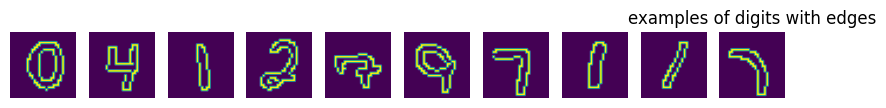

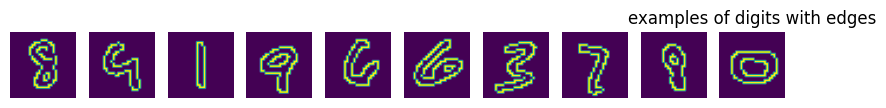


mini score using edges:  0.826
dev score using edges:  0.731

mini score using original data:  0.845
score using original data:  0.809


In [10]:
### STUDENT START ###
import skimage as ski
import skimage.feature
#print(skimage.__version__)

def findEdges(data):
  # init objs
  fig, ax = plt.subplots(1,10, figsize=(10,10))
  sigma = 1.0
  myEdges = []
  edgeIMs = []

  for i in range(data.shape[0]):
    image = data.iloc[i].values.reshape(28,28)
    blurred_image = ski.filters.gaussian(image, sigma=sigma)
    low_t = ski.filters.threshold_otsu(blurred_image)
    high_t = (low_t + 0.6)
    # returns np array of t/f edge locations
    edges = skimage.feature.canny(image=image,
                                sigma=sigma,
                                low_threshold=low_t,
                                high_threshold=high_t)
    edgeIMs.append(edges)
    myEdges.append(edges.flatten())

  # plots of first 10 examples, runs twice, called first using mini, then using dev data
  for i in range(10):
    ax[i].imshow(edgeIMs[i])
    ax[i].axis('off')
  plt.title('examples of digits with edges')
  plt.show()

  return myEdges
### STUDENT END ###


def Q7():
  ### STUDENT START ###
  # filter for edges of images, pre-process
  mini_edges = findEdges(mini_train_data)
  dev_edges = findEdges(dev_data)

  # bern model using edge data
  bern = BernoulliNB()
  bern.fit(mini_edges, mini_train_labels)
  print("\nmini score using edges: ",bern.score(mini_edges, mini_train_labels))
  print("dev score using edges: ",bern.score(dev_edges, dev_labels))

  # bern model using OG data
  bern = BernoulliNB()
  bern.fit(mini_train_data, mini_train_labels)
  print("\nmini score using original data: ",bern.score(mini_train_data, mini_train_labels))
  print("score using original data: ",bern.score(dev_data, dev_labels))



  ### STUDENT END ###

Q7()

Answer: so for this problem, I attempted to add a feature for identifying curves in the data. however, I might have not implemented this correctly as the performance of the model did not improve.